In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
! pip install -U git+https://github.com/qubvel/efficientnet
! pip install tensorflow-addons

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-4par1m8n
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-4par1m8n
     |████████████████████████████████| 50 kB 3.3 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=38b62afadb424f4e279962f14baa6778f62afdc9cc3708aa92bbd28cc9c64062
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub320vd9/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
!unzip /content/gdrive/MyDrive/Faces/Faces.zip -d /content/gdrive/MyDrive/Faces/

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5432.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5433.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5434.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5435.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5436.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5437.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5438.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5439.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/544.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5440.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5441.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5442.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/Real/5443.jpg  
  inflating: /content/gdrive/MyDrive/Faces/Faces/val/

In [13]:
import os
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, InputSpec, Layer, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, MaxPooling2D, MaxPooling1D
from tensorflow_addons.layers import SpatialPyramidPooling2D

In [16]:
from efficientnet.tfkeras import EfficientNetB2 #EfficientNetB0, EfficientNetB1, EfficientNetB2
efficient_net = EfficientNetB2(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False,
)

model = Sequential()
model.add(efficient_net)
model.add(SpatialPyramidPooling2D([1, 2, 4]))
model.add(Flatten(name="flatten"))
model.add(Dense(units = 2, activation = 'softmax'))
model.summary()

31948800/31936256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 7, 7, 1408)       7768562   
 )                                                               
                                                                 
 spatial_pyramid_pooling2d (  (None, 21, 1408)         0         
 SpatialPyramidPooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 29568)             0         
                                                                 
 dense (Dense)               (None, 2)                 59138     
                                                                 
Total params: 7,827,700
Trainable params: 7,760,132
Non-trainable params: 67,568
__________________________________________

In [7]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
train_path = '/content/gdrive/MyDrive/Faces/Faces/train'
val_path = '/content/gdrive/MyDrive/Faces/Faces/val'

In [9]:
checkpoint_filepath = '/content/gdrive/MyDrive/model_checkpoint/'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

Creating Directory: /content/gdrive/MyDrive/model_checkpoint/


In [10]:
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 10,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'SPP2_EfficientNetB2_CELEB.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)
val_generator = val_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Found 80383 images belonging to 2 classes.
Found 20109 images belonging to 2 classes.


In [13]:
len(train_generator)


2512

In [14]:
num_epochs = 20


In [15]:
H = model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)
print(H.history)

Epoch 1/20
2512/2512 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9296
Epoch 1: val_loss improved from inf to 0.05613, saving model to /content/gdrive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5
2512/2512 [==============================] - 29046s 12s/step - loss: 0.1689 - accuracy: 0.9296 - val_loss: 0.0561 - val_accuracy: 0.9794
Epoch 2/20
2512/2512 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9817
Epoch 2: val_loss improved from 0.05613 to 0.03747, saving model to /content/gdrive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5
2512/2512 [==============================] - 1342s 534ms/step - loss: 0.0508 - accuracy: 0.9817 - val_loss: 0.0375 - val_accuracy: 0.9865
Epoch 3/20
2512/2512 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9889
Epoch 3: val_loss improved from 0.03747 to 0.03104, saving model to /content/gdrive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5
2512/2512 [==========

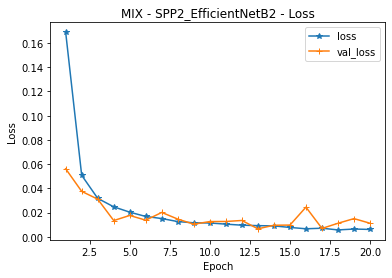

In [16]:
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

import matplotlib.pyplot as plt
epochs = range(1, len(acc) + 1)
plt.plot(epochs, H.history['loss'], label='loss', marker="*")
plt.plot(epochs, H.history['val_loss'], label='val_loss', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MIX - SPP2_EfficientNetB2 - Loss')
plt.legend()
plt.show()

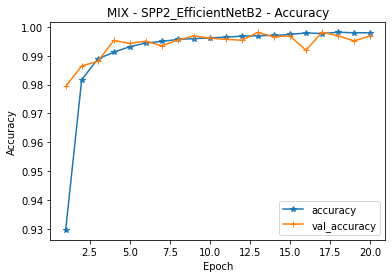

In [17]:
plt.plot(epochs, H.history['accuracy'], label='accuracy', marker="*")
plt.plot(epochs, H.history['val_accuracy'], label='val_accuracy', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MIX - SPP2_EfficientNetB2 - Accuracy')
plt.legend()
plt.show()

Testing


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
test_path = '/content/gdrive/MyDrive/Faces/Faces/test'
test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    classes=['Real', 'Fake'],
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

Found 35210 images belonging to 2 classes.


In [17]:
new_model = load_model('/content/gdrive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5',
                       custom_objects={'SpatialPyramidPooling2D': SpatialPyramidPooling2D})

In [18]:
test_generator.reset()
preds = new_model.predict(test_generator, verbose = 1)

35210/35210 [==============================] - 5898s 167ms/step


In [19]:
print(preds)


[[1.9016923e-11 1.0000000e+00]
 [1.4797415e-04 9.9985206e-01]
 [6.1296082e-01 3.8703918e-01]
 ...
 [8.4168476e-01 1.5831526e-01]
 [1.0000000e+00 1.3908271e-08]
 [9.9999690e-01 3.0525805e-06]]


In [20]:
from keras.utils import np_utils
from imutils import paths
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import os

path_reals = list(paths.list_images('/content/gdrive/MyDrive/Faces/Faces/test/Real'))
labels_real = []

for path_real in path_reals:
	label2 = path_real.split(os.path.sep)[-2]
	labels_real.append(label2)
 
path_fakes = list(paths.list_images('/content/gdrive/MyDrive/Faces/Faces/test/Fake'))
labels_fake = []

for path_fake in path_fakes:
	label3 = path_fake.split(os.path.sep)[-2]
	labels_fake.append(label3)
 
labels_test = labels_real + labels_fake

In [21]:
print(labels_test[2])
print(labels_test[30000])

Real
Fake


In [22]:
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)
labels_test = np_utils.to_categorical(labels_test, 2)

f = open('/content/gdrive/MyDrive/le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()

In [23]:
print(labels_test[2])
print(labels_test[30000])

[0. 1.]
[1. 0.]


In [24]:
from sklearn.metrics import classification_report

test = np.argmin(labels_test, axis=1)
pred = np.argmin(preds, axis=1)
print(classification_report(test, pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

        Fake    0.98642   0.95268   0.96926      8770
        Real    0.98448   0.99565   0.99003     26440

    accuracy                        0.98495     35210
   macro avg    0.98545   0.97417   0.97965     35210
weighted avg    0.98496   0.98495   0.98486     35210



[[ 8355   415]
 [  115 26325]]


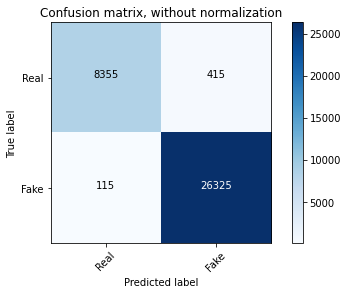

In [25]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test, pred)
print(cnf_matrix)
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
class_names = ['Real', 'Fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [26]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(test, pred, pos_label=1)

fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("tpr = ", tpr)
print("fpr = ", fpr)
print("eer = ", eer)

tpr =  [0.         0.99565053 1.        ]
fpr =  [0.         0.04732041 1.        ]
eer =  0.004349470499243613


In [27]:
test = np.argmin(labels_test, axis=1)
true = preds[:, 0]
print(true)

[1.9016923e-11 1.4797415e-04 6.1296082e-01 ... 8.4168476e-01 1.0000000e+00
 9.9999690e-01]


threshold at eer =  0.9881343
eer =  0.016187594553706552


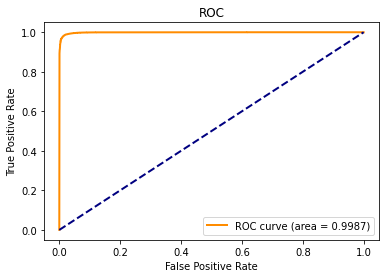

In [28]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from itertools import cycle

fpr, tpr, threshold = roc_curve(test, true, pos_label=1)
fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("threshold at eer = ", eer_threshold)
print("eer = ", eer)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [29]:
import numpy as np

from scipy import interpolate

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def cal_metric(groundTruth, predicted):
    fpr, tpr, thresholds = roc_curve(groundTruth, predicted)
    y = (tpr)
    x = (fpr)
    z = tpr + fpr
    tpr = tpr.reshape((tpr.shape[0], 1))
    fpr = fpr.reshape((fpr.shape[0], 1))
    xnew = np.arange(0, 1, 0.0000001)
    func = interpolate.interp1d(x, y)
    # frr = fpr
    ynew = func(xnew)

    znew = abs(xnew + ynew - 1)

    eer = xnew[np.argmin(znew)]
    print('EER =', eer)
    # interpolate thresholds
    func_2 = interpolate.interp1d(x, thresholds)
    thresholds_new = func_2(xnew)

    print("Threshold at eer: {}".format(thresholds_new[np.argmin(znew)]))

    FPR = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    TPRs = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    for i, (key, value) in enumerate(FPR.items()):
        index = np.argwhere(xnew == value)

        score = ynew[index]

        TPRs[key] = float(np.squeeze(score))
    #	    print(key, score)

    auc = roc_auc_score(groundTruth, predicted)
    print('AUC = ', auc)
    print ('TPRs = ', TPRs)
    if 1:
        plt.plot(xnew, ynew)
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return eer, TPRs, auc, {'x': xnew, 'y': ynew}

EER = 0.0161916
Threshold at eer: 0.988134245732069
AUC =  0.9987174851689763
TPRs =  {'TPR(1.%)': 0.974234114977307, 'TPR(.5%)': 0.9614920574886535}


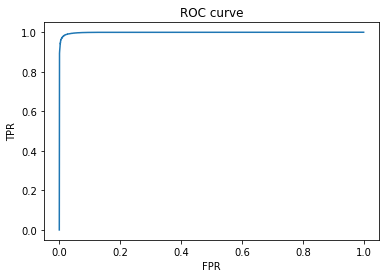

(0.0161916,
 {'TPR(.5%)': 0.9614920574886535, 'TPR(1.%)': 0.974234114977307},
 0.9987174851689763,
 {'x': array([0.000000e+00, 1.000000e-07, 2.000000e-07, ..., 9.999997e-01,
         9.999998e-01, 9.999999e-01]),
  'y': array([0.00000000e+00, 2.49257287e-04, 4.98514574e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])})

In [30]:
cal_metric(test, true)
